In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import IsolationForest

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.callbacks import EarlyStopping

import warnings  # The warnings module to handle warnings during code execution

# Suppress warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the dataset
data = pd.read_csv("data_after_EDA.csv")
nlp_data = pd.read_csv('updated_dataset_2.csv')

# Display the first few rows to understand the structure
print(data.head())
print(nlp_data.head())

  ROWNUM                                  Hospital Eligibility Class  Gender  \
0      1  Royal Commission Health Services Program  ROYAL COMMISSION  Female   
1      2  Royal Commission Health Services Program  ROYAL COMMISSION  Female   
2      3  Royal Commission Health Services Program  ROYAL COMMISSION  Female   
3      4  Royal Commission Health Services Program  ROYAL COMMISSION  Female   
4      5  Royal Commission Health Services Program  ROYAL COMMISSION  Female   

          Arrival Time Severity Level           Deparment  \
0  2023-12-13 13:17:48        Level Ⅳ  Emergency Medicine   
1  2023-12-08 10:59:28        Level Ⅲ  Emergency Medicine   
2  2023-11-05 14:03:02        Level Ⅲ  Emergency Medicine   
3  2023-10-07 22:57:41        Level Ⅲ  Emergency Medicine   
4  2023-10-21 21:32:17        Level Ⅳ  Emergency Medicine   

                                   Main Diagnosis       Discharge Time  \
0                               Pain, unspecified  2023-12-13 16:43:00   
1   

In [3]:
print(data.columns)

Index(['ROWNUM', 'Hospital', 'Eligibility Class', 'Gender', 'Arrival Time',
       'Severity Level', 'Deparment', 'Main Diagnosis', 'Discharge Time',
       'Waiting Time (Minutes)', 'Length of Stay (Minutes)',
       'Treatment Time(Minutes)', 'Cluster', 'No Treatment'],
      dtype='object')


In [4]:
# Drop the 'Main Diagnosis' column
data.drop(columns=['Main Diagnosis','Discharge Time'], inplace=True)

# Convert Arrival Time and Discharge Time to datetime
data['Arrival Time'] = pd.to_datetime(data['Arrival Time'])
data['Date'] = pd.to_datetime(data['Arrival Time']).dt.date
data['Hour'] = data['Arrival Time'].dt.hour
data['DayOfYear'] = data['Arrival Time'].dt.dayofyear
data['Month'] = data['Arrival Time'].dt.month
data['Hour'] = data['Arrival Time'].dt.hour
data['Weekday'] = data['Arrival Time'].dt.weekday + 1

# Convert Gender to numerical
gender_mapping = {'Female': 0, 'Male': 1}
data['Gender_num'] = data['Gender'].map(gender_mapping)

# Convert the 'Severity Level' column to numerical
level_mapping = {
    'Level Ⅰ': 1,
    'Level Ⅱ': 2,
    'Level Ⅲ': 3,
    'Level Ⅳ': 4,
    'Level Ⅴ': 5,
    'Unrated': 0
}

data = data[data['Severity Level'] != 'Unrated']

data['Severity Level'] = data['Severity Level'].replace(level_mapping)
data['Severity Level'] = data['Severity Level'].astype(int)

print(data.head())

  ROWNUM                                  Hospital Eligibility Class  Gender  \
0      1  Royal Commission Health Services Program  ROYAL COMMISSION  Female   
1      2  Royal Commission Health Services Program  ROYAL COMMISSION  Female   
2      3  Royal Commission Health Services Program  ROYAL COMMISSION  Female   
3      4  Royal Commission Health Services Program  ROYAL COMMISSION  Female   
4      5  Royal Commission Health Services Program  ROYAL COMMISSION  Female   

         Arrival Time  Severity Level           Deparment  \
0 2023-12-13 13:17:48               4  Emergency Medicine   
1 2023-12-08 10:59:28               3  Emergency Medicine   
2 2023-11-05 14:03:02               3  Emergency Medicine   
3 2023-10-07 22:57:41               3  Emergency Medicine   
4 2023-10-21 21:32:17               4  Emergency Medicine   

   Waiting Time (Minutes)  Length of Stay (Minutes)  Treatment Time(Minutes)  \
0                    14.0                     205.0                    1

In [5]:
# Combine the data with the NLP data
combined_data = data.join(nlp_data, how='left')

In [6]:
# Generate list of NLP feature and time feature columns
feature_columns = nlp_data.columns[1:].tolist()
feature_columns += ['Month', 'Hour', 'Weekday']
# Fill missing values with 0 before scaling
combined_data[feature_columns] = combined_data[feature_columns].fillna(0)

# Scale features to [0, 1] - important for neural network models
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(combined_data[feature_columns])

# Reshape data for LSTM [samples, time steps, features]
time_steps = 1  # Each sequence consists of a single time step with multiple features
scaled_features = scaled_features.reshape((scaled_features.shape[0], time_steps, scaled_features.shape[1]))

In [7]:
# Weather Data
weather_data = pd.read_csv('Jubail_weather_2023 copy.csv')

weather_data.drop(columns=['name'], inplace=True)

weather_data['datetime'] = pd.to_datetime(weather_data['datetime']).dt.date
weather_data.rename(columns={'datetime': 'Date'}, inplace=True)
print(weather_data.head())

         Date  tempmax  tempmin  temp  feelslikemax  feelslikemin  feelslike  \
0  2023-01-01     25.0     17.3  21.7          25.0          17.3       21.7   
1  2023-01-02     25.6     17.2  21.8          25.6          17.2       21.8   
2  2023-01-03     26.0     20.1  22.5          26.0          20.1       22.5   
3  2023-01-04     27.0     19.2  22.6          26.6          19.2       22.6   
4  2023-01-05     28.0     20.1  23.5          27.4          20.1       23.4   

    dew  humidity  precip  ...  solarenergy  uvindex severerisk  \
0  14.4      63.7     0.0  ...         37.4       10         10   
1  13.0      60.1     0.0  ...         35.1       10         10   
2  10.8      48.1     0.0  ...         34.4        9         10   
3   8.4      41.4     0.0  ...         22.8        6         10   
4  10.9      45.7     0.0  ...         16.6        7         10   

               sunrise               sunset  moonphase        conditions  \
0  2023-01-01T07:04:18  2023-01-01T17:39

# Autoencoder

In [8]:
# Split the data into training and testing sets
X_train, X_test = train_test_split(scaled_features, test_size=0.2, random_state=42, shuffle=True)
print("Input shape:", X_train.shape)

Input shape: (76100, 1, 123)


In [9]:
# Build the Autoencoder Model

# Autoencoder Model with LSTM
input_layer = Input(shape=(time_steps, X_train.shape[2]))

# Encoder with LSTM
encoded = LSTM(128, activation='relu', return_sequences=True)(input_layer)
encoded = LSTM(64, activation='relu', return_sequences=False)(encoded)

# Repeat the encoded features
repeated = RepeatVector(time_steps)(encoded)

# Decoder with LSTM
decoded = LSTM(64, activation='relu', return_sequences=True)(repeated)
decoded = LSTM(128, activation='relu', return_sequences=True)(decoded)
output_layer = TimeDistributed(Dense(X_train.shape[2], activation='sigmoid'))(decoded)

# Model
autoencoder = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
from tensorflow.keras.optimizers import Adam
autoencoder.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

In [10]:
# Train the autoencoder
callbacks = [EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]

history = autoencoder.fit(X_train, X_train, 
                          epochs=50, 
                          batch_size=256, 
                          shuffle=True,
                          validation_data=(X_test, X_test),
                          callbacks=callbacks,
                          verbose=1)

Epoch 1/50
298/298 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.2431 - val_loss: 0.1970
Epoch 2/50
298/298 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0919 - val_loss: 0.0212
Epoch 3/50
298/298 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0209 - val_loss: 0.0203
Epoch 4/50
298/298 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0202 - val_loss: 0.0201
Epoch 5/50
298/298 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0200 - val_loss: 0.0199
Epoch 6/50
298/298 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0199 - val_loss: 0.0198
Epoch 7/50
298/298 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0198 - val_loss: 0.0197
Epoch 8/50
298/298 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0198 - val_loss: 0.0197
Epoch 9/50
298/298 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0198 - val_loss: 0.0197
Epoch 10/50
298/298 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0197 - val_loss: 0.0196
Epoch 11/50
298/298 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0196 - val_loss: 0.0194
Epoch 12/50
298/298 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

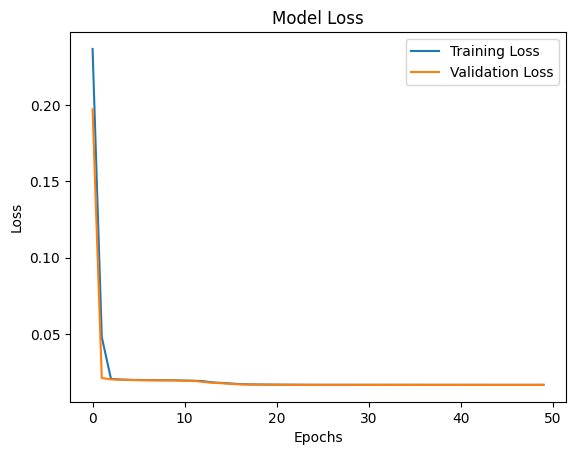

In [11]:
# Plot training loss and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

595/595 ━━━━━━━━━━━━━━━━━━━━ 1s 916us/step
MSE Threshold: 0.27062417399451644


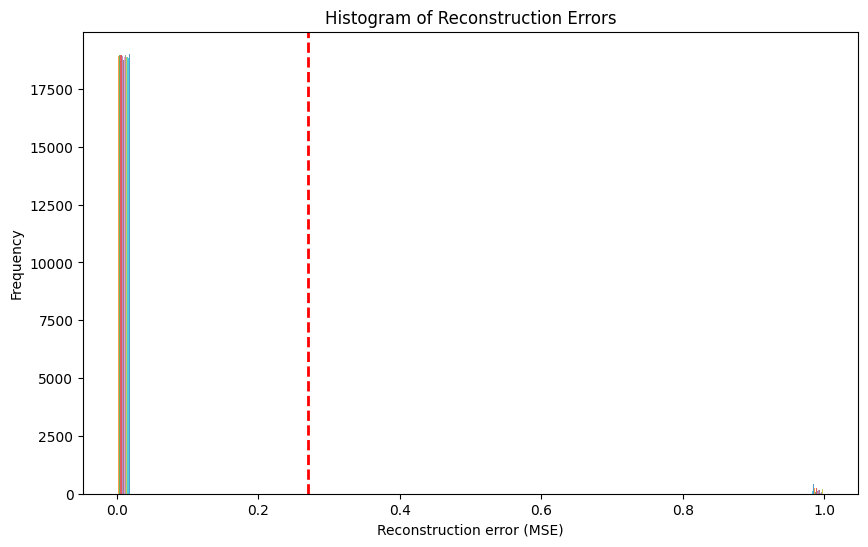

In [12]:
# Get the reconstruction loss on the test set
predictions = autoencoder.predict(X_test)

# Compute reconstruction error
mse = np.mean(np.power(X_test - predictions, 2), axis=1)

mse_threshold = np.mean(mse) + 2*np.std(mse)
print(f"MSE Threshold: {mse_threshold}")

plt.figure(figsize=(10, 6))
plt.hist(mse, bins=50, alpha=0.75)
plt.axvline(mse_threshold, color='red', linestyle='dashed', linewidth=2)
plt.title('Histogram of Reconstruction Errors')
plt.xlabel('Reconstruction error (MSE)')
plt.ylabel('Frequency')
plt.show()

Example MSE values: [5.54450288e-67 2.22139619e-63 6.10828440e-69 0.00000000e+00
 9.49802562e-74]


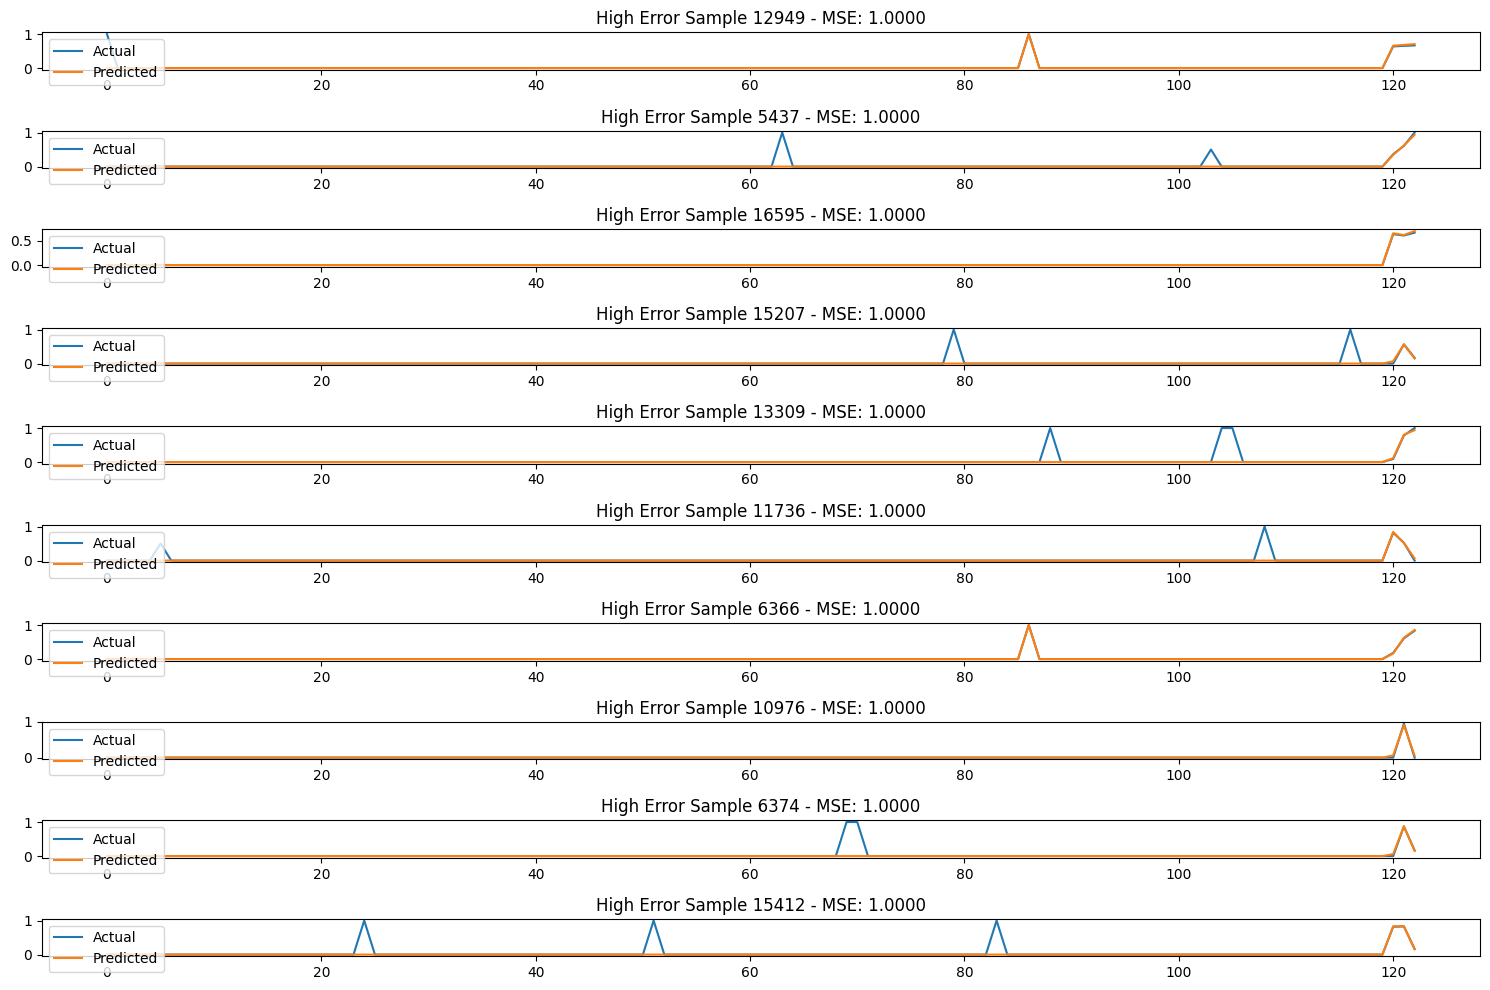

In [13]:
mse = np.array(mse).flatten()
print("Example MSE values:", mse[:5])

# Find indices of high MSE errors that are within the bound of X_test's size
high_error_indices = np.where(mse > mse_threshold)[0]

# Ensuring the indices are within the bounds of X_test and predictions
high_error_indices = high_error_indices[high_error_indices < X_test.shape[0]]

# Choose a number of high-error samples to visualize
num_samples = min(10, len(high_error_indices))
selected_samples = np.random.choice(high_error_indices, size=num_samples, replace=False)

# Plotting the high-error samples
plt.figure(figsize=(15, 10))
for i, index in enumerate(selected_samples, 1):
    plt.subplot(num_samples, 1, i)
    plt.plot(X_test[index].flatten(), label='Actual')
    plt.plot(predictions[index].flatten(), label='Predicted')
    mse_value = mse[index]
    plt.title(f'High Error Sample {index} - MSE: {mse_value:.4f}')
    plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


## Anomaly Date Analysis

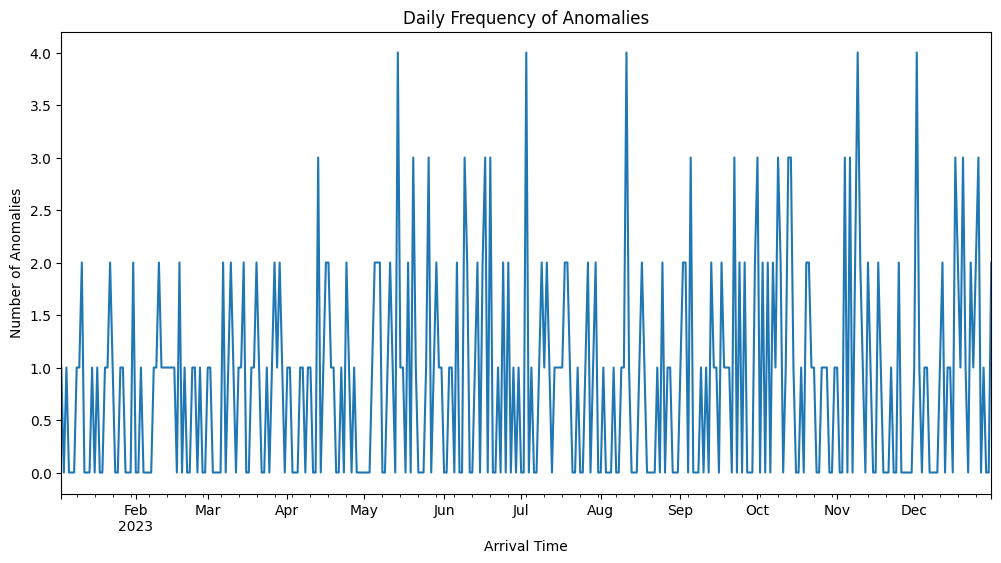

In [14]:
import pandas as pd

# Assuming you have df_auto with 'Arrival Time' column (datetime.date)

# Fix performance and setting warnings (optional)
df_auto = combined_data.iloc[high_error_indices]
df_auto['MSE'] = mse[high_error_indices]  # Adding the MSE values to the DataFrame
df_auto['Count'] = 1

plt.figure(figsize=(12, 6))

# Set index to 'Arrival Time'
df_auto.set_index('Arrival Time', inplace=True)

# Count anomalies per day
daily_anomalies = df_auto.resample('D').size()

# Plot daily anomalies
daily_anomalies.plot(title='Daily Frequency of Anomalies', ylabel='Number of Anomalies')
plt.show()

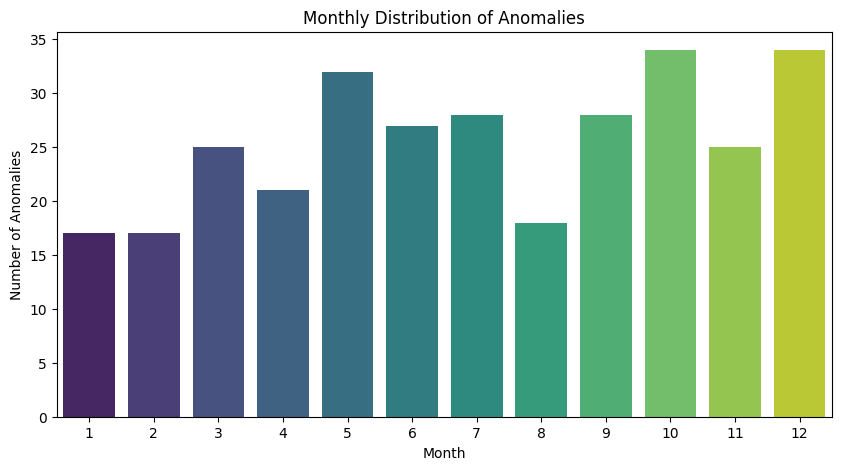

In [15]:
# Plot the monthly distribution of anomalies
monthly_counts_auto = df_auto['Month'].value_counts().sort_index()
plt.figure(figsize=(10, 5))
sns.barplot(x=monthly_counts_auto.index, y=monthly_counts_auto.values, palette='viridis')
plt.title('Monthly Distribution of Anomalies')
plt.xlabel('Month')
plt.ylabel('Number of Anomalies')
plt.show()

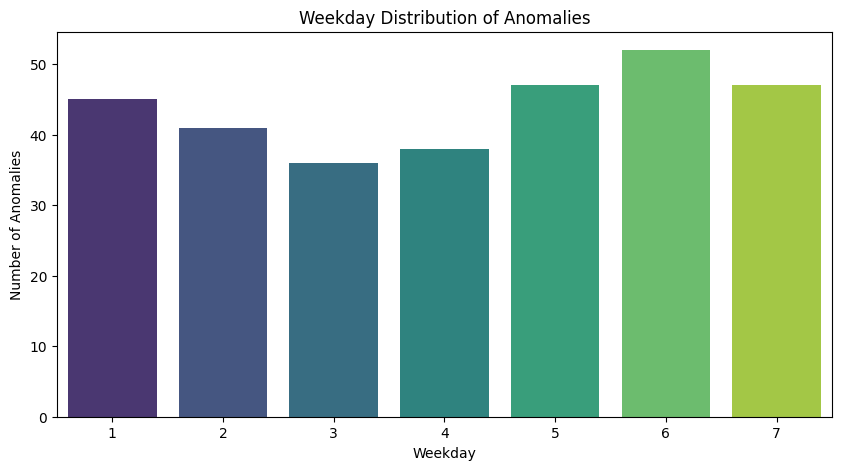

In [16]:
# Weekday Distribution of Anomalies
weekday_counts_auto = df_auto['Weekday'].value_counts().sort_index()
plt.figure(figsize=(10, 5))
sns.barplot(x=weekday_counts_auto.index, y=weekday_counts_auto.values, palette='viridis')
plt.title('Weekday Distribution of Anomalies')
plt.xlabel('Weekday')
plt.ylabel('Number of Anomalies')
plt.show()

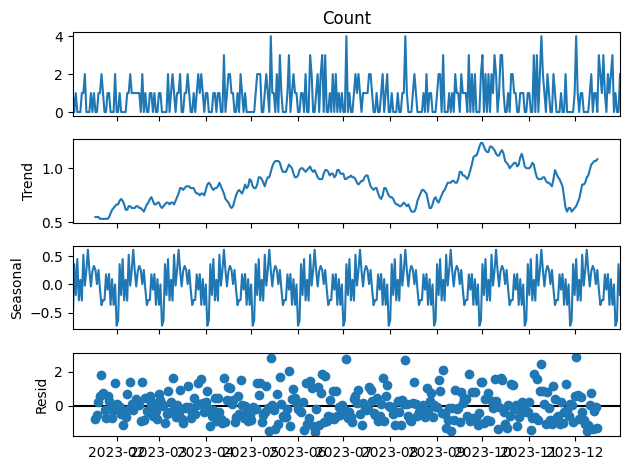

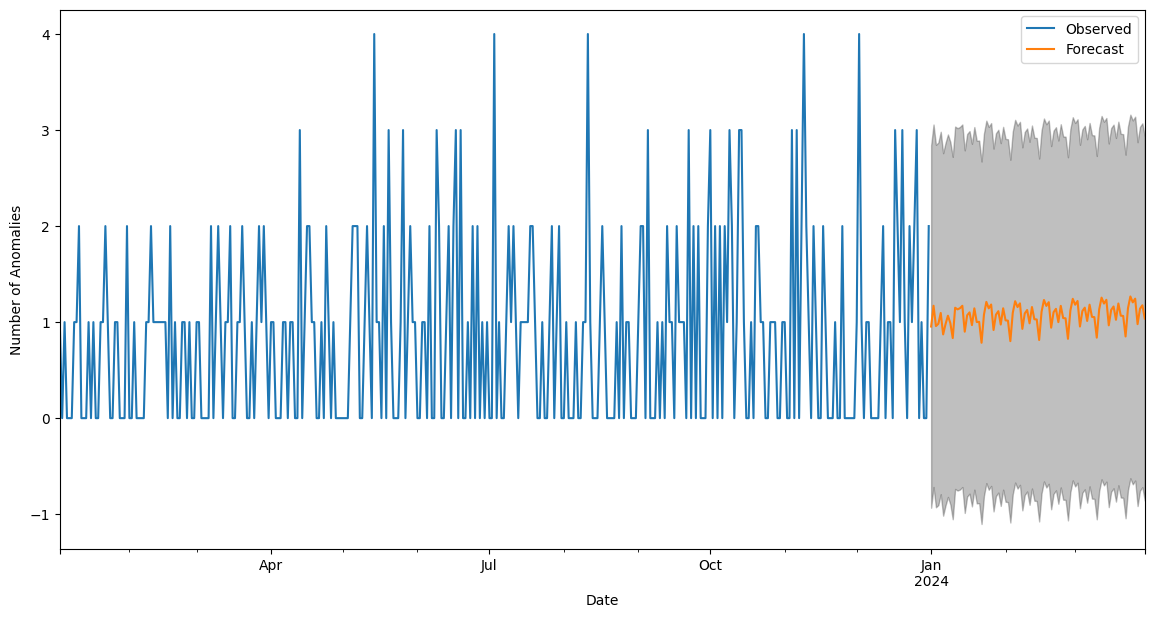

In [19]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

df_auto['Count'] = 1

# Resample 'Count' and sum by day (assuming 'Arrival Time' is the index)
daily_anomalies_auto = df_auto.resample('D')['Count'].sum()

# Seasonal Decomposition
result = seasonal_decompose(daily_anomalies_auto, model='additive', period=30)  # Assuming monthly seasonality
result.plot()
plt.show()

# SARIMAX Model
model = SARIMAX(daily_anomalies_auto, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
fitted_model = model.fit(disp=False)

# Predict the next 90 days (assuming daily data)
preds = fitted_model.get_forecast(steps=90)
pred_ci = preds.conf_int()

# Visualize the Predictions
plt.figure(figsize=(14, 7))
daily_anomalies_auto.plot(label='Observed')
preds.predicted_mean.plot(label='Forecast')
ax = plt.gca()  # Get current axis for filling confidence interval
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')  # Change label if not daily data
ax.set_ylabel('Number of Anomalies')
plt.legend()
plt.show()

## Weather

In [20]:
# Weather Data
# Assuming anomalies_data_auto has a 'Date' column in date format
# Combine the anomalies data with weather data
matched_weather = pd.merge(df_auto['Date'], weather_data, on='Date', how='inner').sort_values(by='Date')
print(matched_weather.head())

           Date  tempmax  tempmin  temp  feelslikemax  feelslikemin  \
59   2023-01-03     26.0     20.1  22.5          26.0          20.1   
133  2023-01-05     28.0     20.1  23.5          27.4          20.1   
224  2023-01-09     24.0     17.6  21.0          24.0          17.6   
86   2023-01-10     29.0     17.8  22.5          28.9          17.8   
282  2023-01-11     23.0     20.6  22.0          23.0          20.6   

     feelslike   dew  humidity  precip  ...  solarenergy  uvindex severerisk  \
59        22.5  10.8      48.1     0.0  ...         34.4        9         10   
133       23.4  10.9      45.7     0.0  ...         16.6        7         10   
224       21.0  14.3      66.1     0.0  ...         37.6       10         10   
86        22.6  16.2      69.0     0.2  ...         35.1       10         10   
282       22.0  13.1      57.5     0.0  ...         24.0        8         10   

                 sunrise               sunset  moonphase        conditions  \
59   2023-01-0

In [21]:
matched_weather.describe()

,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,...,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase
count,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,...,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000
mean,34.957190,25.838889,30.116993,37.952288,27.788889,32.826144,17.827451,51.038235,0.181373,9.803922,...,23.833007,221.102288,1008.651307,19.185621,9.265686,281.270915,24.310784,8.490196,24.062092,0.511928
std,6.102724,5.859174,5.705842,9.711893,8.151758,8.642956,5.523134,12.101958,1.488606,29.785475,...,4.628995,107.937523,7.301566,18.387920,1.061131,96.093841,8.305936,1.955631,20.649282,0.299970
min,18.200000,13.900000,15.900000,18.200000,13.900000,15.900000,4.200000,19.100000,0.000000,0.000000,...,13.400000,3.400000,995.000000,0.000000,5.300000,27.800000,2.400000,1.000000,10.000000,0.000000
25%,29.000000,20.600000,25.100000,29.025000,20.600000,25.000000,13.400000,43.900000,0.000000,0.000000,...,20.700000,104.675000,1002.400000,3.700000,8.850000,210.900000,18.175000,8.000000,10.000000,0.250000
50%,36.000000,26.750000,31.200000,37.400000,26.750000,31.650000,17.550000,53.200000,0.000000,0.000000,...,22.800000,255.000000,1009.450000,13.500000,9.800000,277.400000,23.900000,9.000000,10.000000,0.550000
75%,40.000000,30.850000,35.000000,47.400000,34.675000,41.425000,22.700000,59.500000,0.000000,0.000000,...,25.700000,303.925000,1014.975000,28.675000,10.000000,370.700000,32.175000,10.000000,30.000000,0.770000
max,46.000000,36.200000,40.000000,59.600000,43.400000,48.400000,27.500000,86.400000,23.800000,100.000000,...,44.900000,359.900000,1023.500000,77.500000,10.600000,499.400000,43.200000,10.000000,100.000000,0.980000


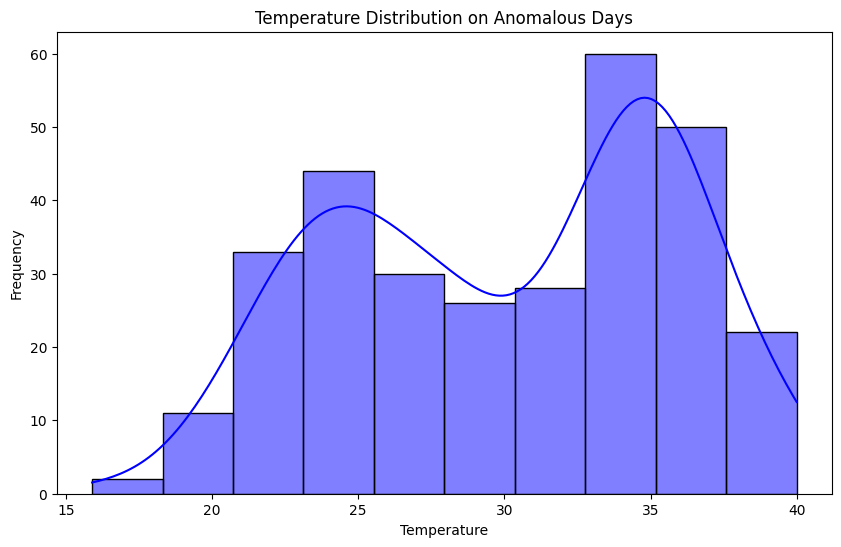

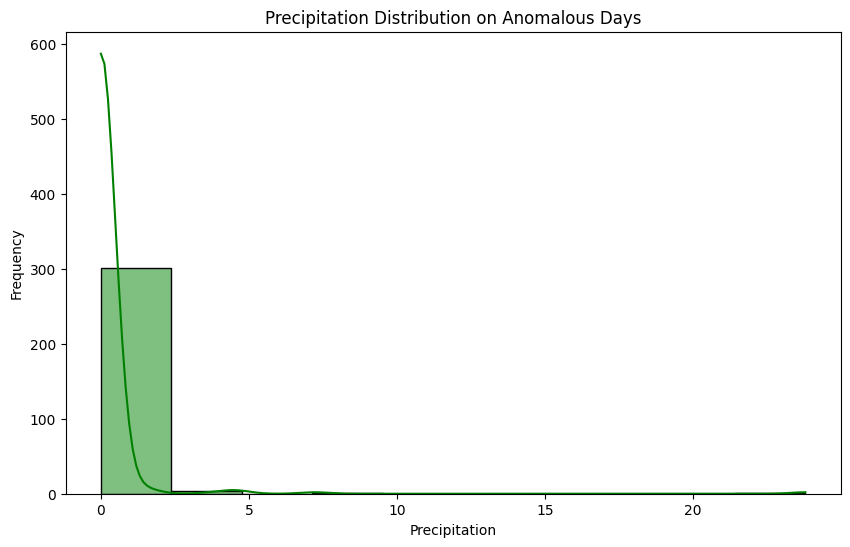

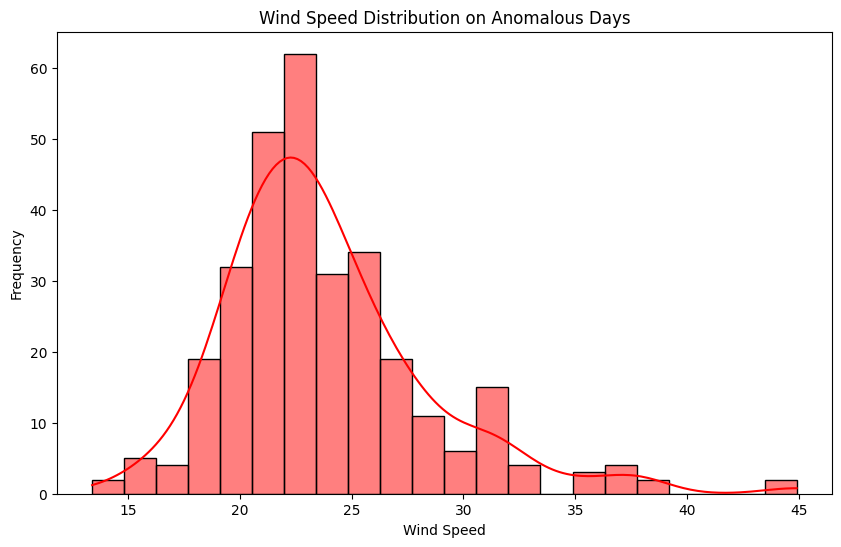

In [22]:
# Plot the weather features on anomalous days

# Temperature
plt.figure(figsize=(10, 6))
sns.histplot(matched_weather['temp'], kde=True, color='blue')
plt.title('Temperature Distribution on Anomalous Days')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()

# Precipitation
plt.figure(figsize=(10, 6))
sns.histplot(matched_weather['precip'], kde=True, color='green')
plt.title('Precipitation Distribution on Anomalous Days')
plt.xlabel('Precipitation')
plt.ylabel('Frequency')
plt.show()

# Wind Speed
plt.figure(figsize=(10, 6))
sns.histplot(matched_weather['windspeed'], kde=True, color='red')
plt.title('Wind Speed Distribution on Anomalous Days')
plt.xlabel('Wind Speed')
plt.ylabel('Frequency')
plt.show()

## Anomaly Main Diagnosis

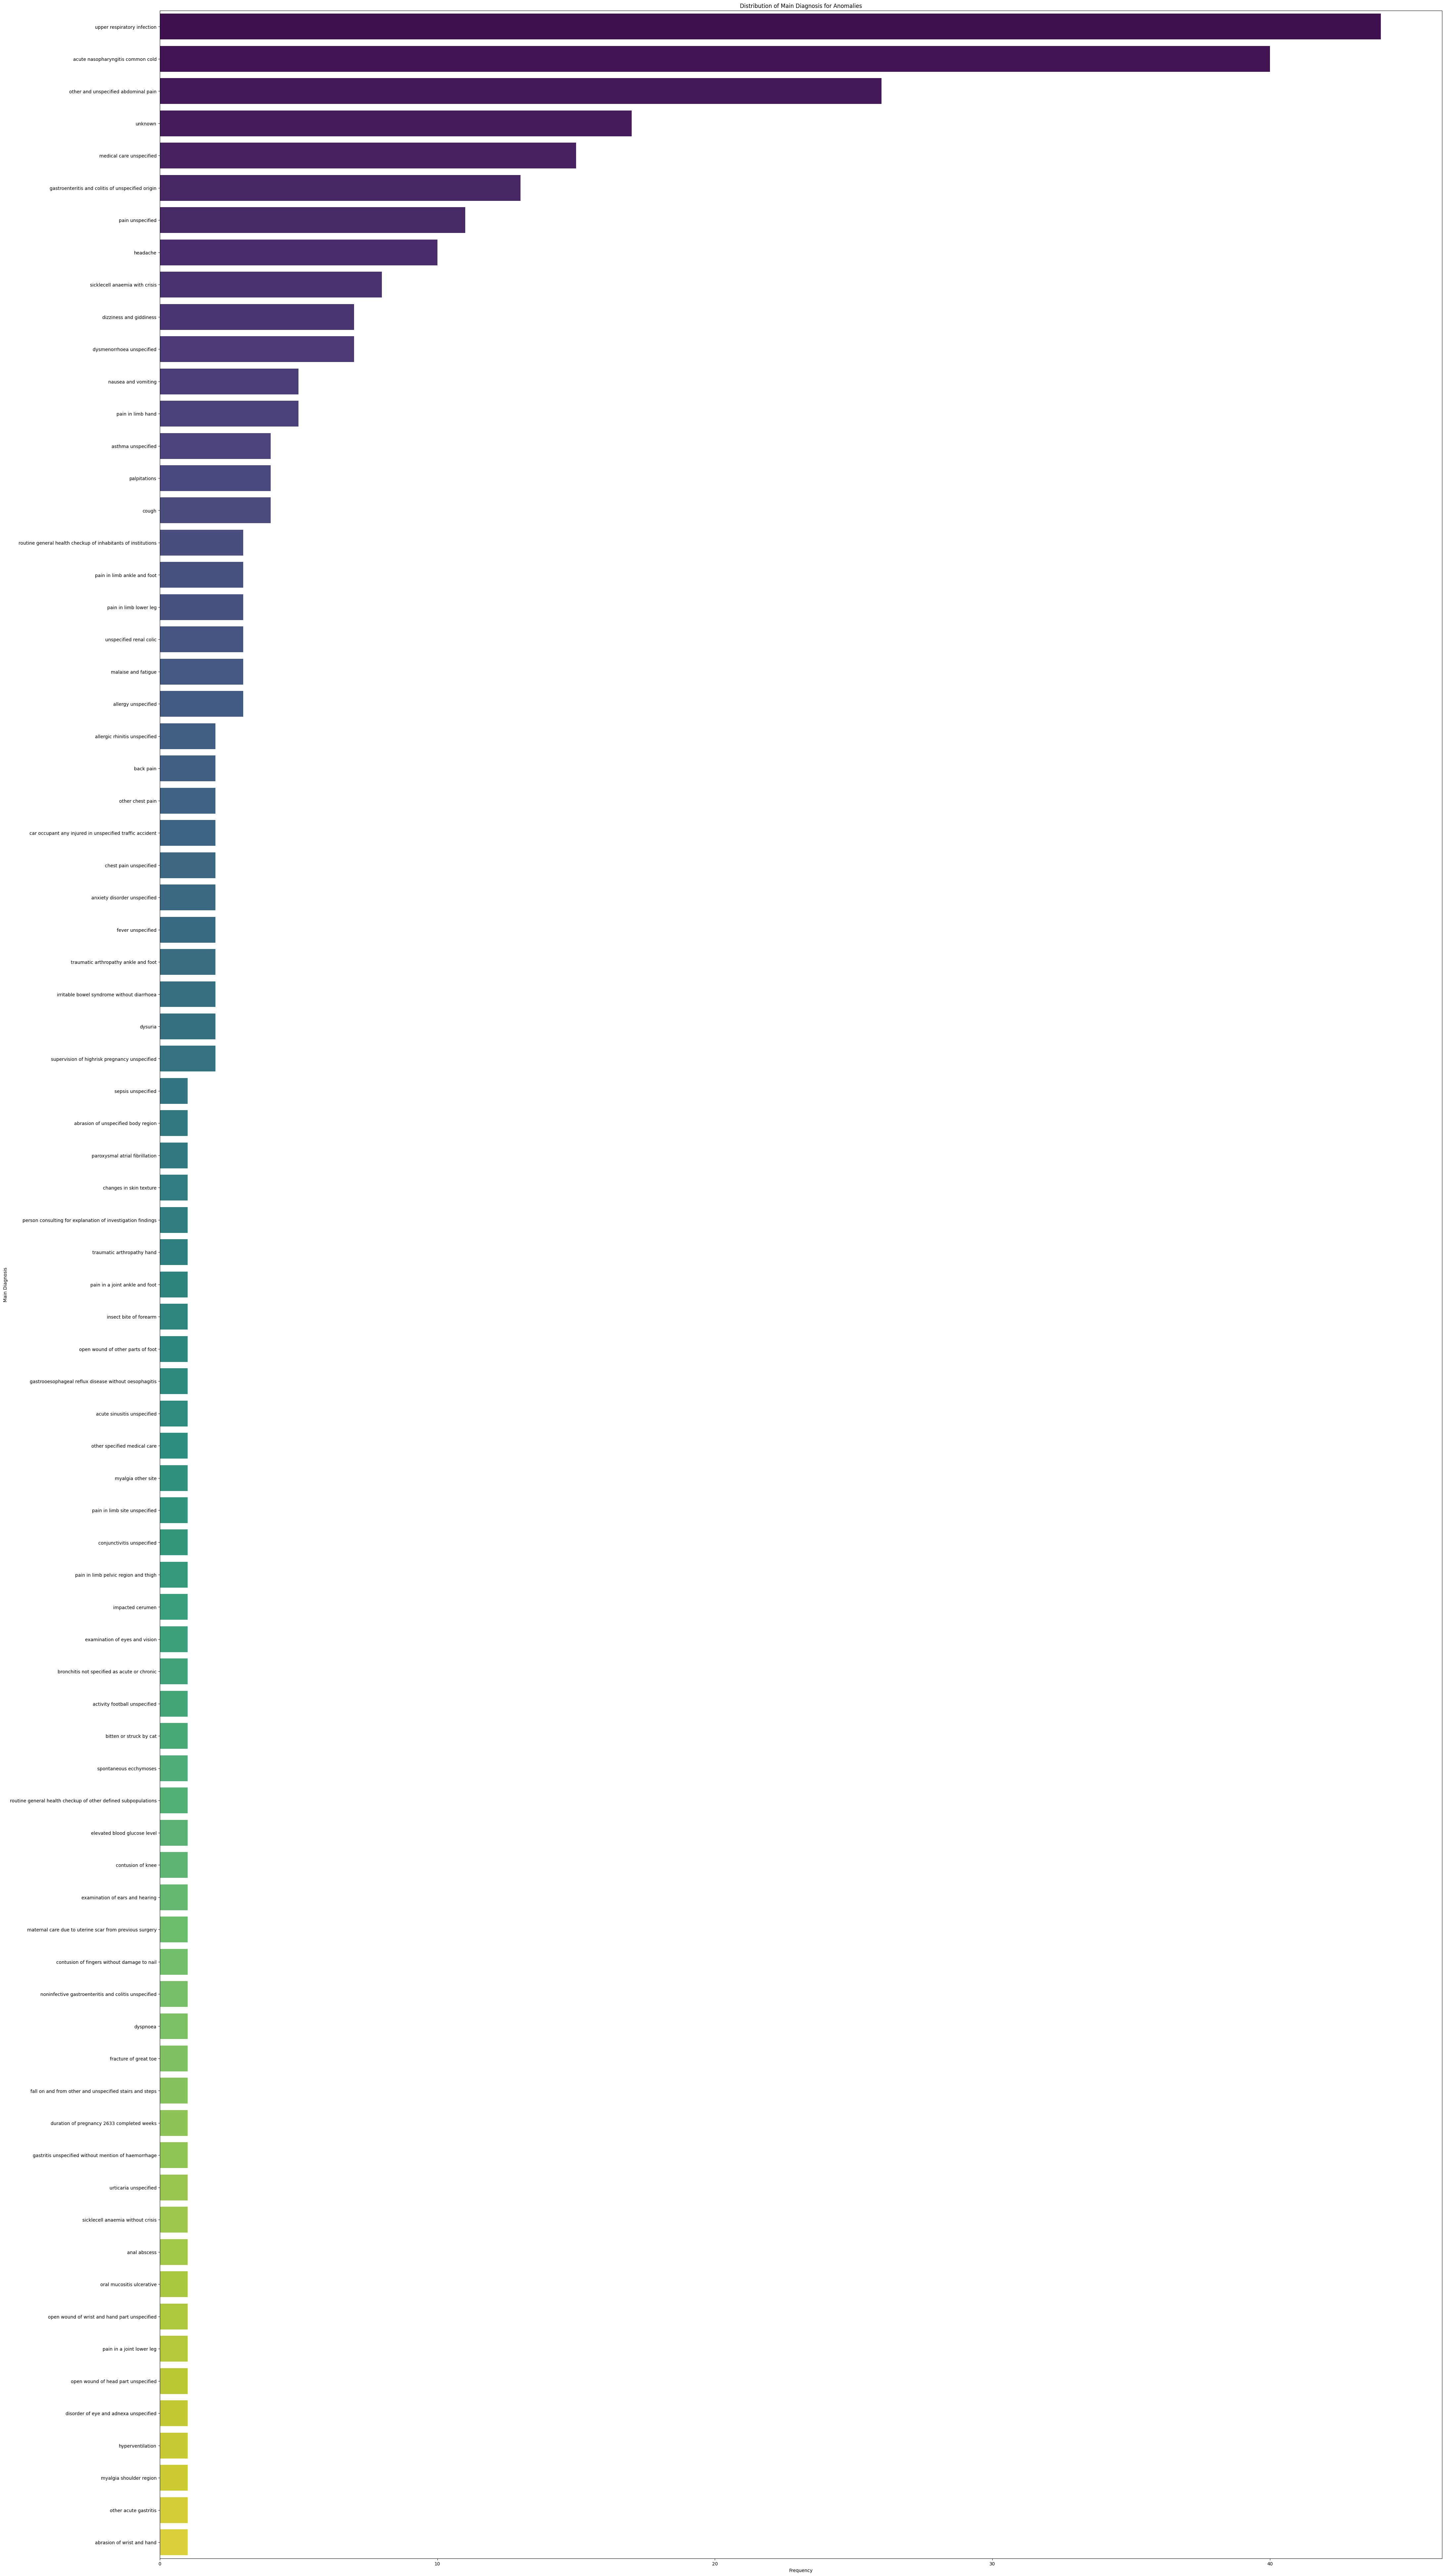

Arrival Time
2023-01-03 23:14:26                             medical care unspecified
2023-01-05 02:40:43                               pain in limb lower leg
2023-01-09 20:17:38                          upper respiratory infection
2023-01-10 08:17:34                 other and unspecified abdominal pain
2023-01-11 05:37:10                 other and unspecified abdominal pain
                                             ...                        
2023-12-26 12:05:06    routine general health checkup of inhabitants ...
2023-12-26 20:20:58                    acute nasopharyngitis common cold
2023-12-28 07:28:13                 other and unspecified abdominal pain
2023-12-31 19:25:19                                     pain unspecified
2023-12-31 22:26:26                                             headache
Name: Main Diagnosis, Length: 306, dtype: object


In [24]:
plt.figure(figsize=(50, 100))
sns.countplot(y='Main Diagnosis', data=df_auto, order=df_auto['Main Diagnosis'].value_counts().index,palette='viridis')
plt.title('Distribution of Main Diagnosis for Anomalies')
plt.xlabel('Frequency')
plt.show()

df_auto_sorted = df_auto.sort_index()
print(df_auto_sorted['Main Diagnosis'])

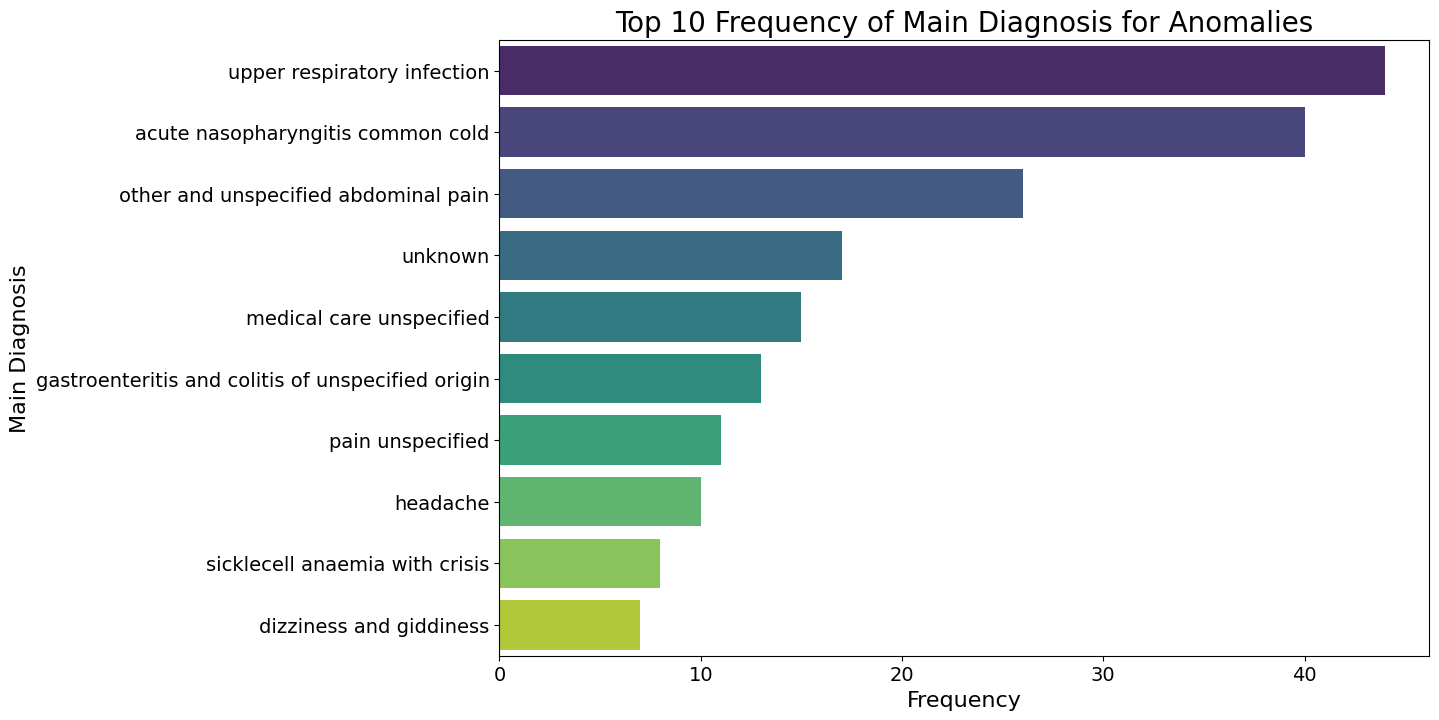

Top 10 Anomalous Main Diagnoses (Autoencoder):
1. upper respiratory infection
2. acute nasopharyngitis common cold
3. other and unspecified abdominal pain
4. unknown
5. medical care unspecified
6. gastroenteritis and colitis of unspecified origin
7. pain unspecified
8. headache
9. sicklecell anaemia with crisis
10. dizziness and giddiness


In [25]:
# Caculate the frequency of diagnoses and sort the top 10
diagnosis_counts_auto = df_auto['Main Diagnosis'].value_counts().nlargest(10)

# Plot the frequency of the top 10 diagnoses
plt.figure(figsize=(12, 8))
sns.barplot(y=diagnosis_counts_auto.index, x=diagnosis_counts_auto.values, palette='viridis')

plt.title('Top 10 Frequency of Main Diagnosis for Anomalies', fontsize=20)
plt.xlabel('Frequency', fontsize=16)
plt.ylabel('Main Diagnosis', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

print("Top 10 Anomalous Main Diagnoses (Autoencoder):")
for idx, diagnosis in enumerate(diagnosis_counts_auto.index, start=1):
    print(f"{idx}. {diagnosis}")

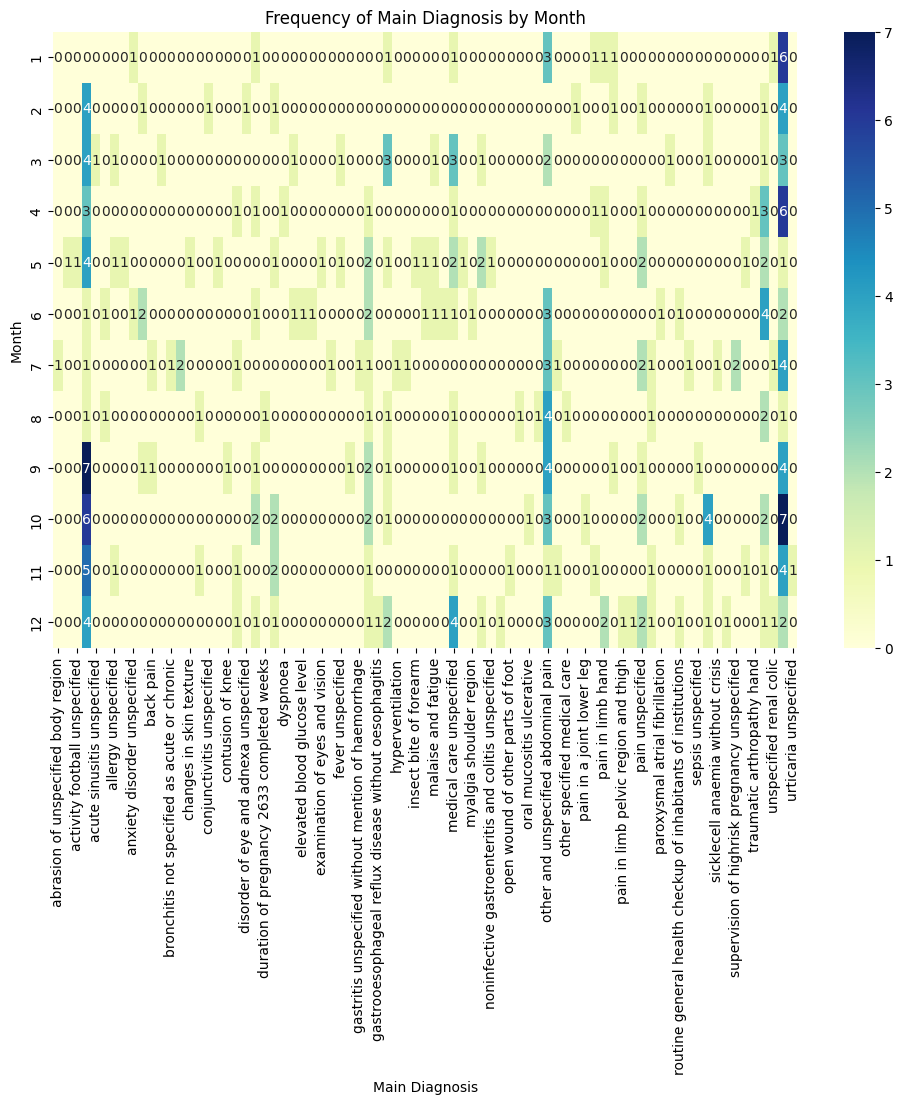

In [26]:
# Group by Month and 'Main Diagnosis' and count occurrences
monthly_diagnosis = df_auto.groupby(['Month', 'Main Diagnosis']).size().unstack(fill_value=0)

# Visualize the data
plt.figure(figsize=(12, 8))
sns.heatmap(monthly_diagnosis, annot=True, cmap="YlGnBu", fmt="d")
plt.title('Frequency of Main Diagnosis by Month')
plt.xlabel('Main Diagnosis')
plt.ylabel('Month')
plt.show()

Frequency of Main Diagnosis by Month:

The colors in the heatmap range from light to dark. The darker the color, the higher the frequency of that particular diagnosis in the specified month.

In [27]:
# Select diagnoses with frequency greater than or equal to 5 in the specific month
high_frequency_diagnoses = {}
for month in monthly_diagnosis.index:
    filtered_diagnoses = monthly_diagnosis.loc[month][monthly_diagnosis.loc[month] >= 5]
    if not filtered_diagnoses.empty:  # If there are any diagnoses
        high_frequency_diagnoses[month] = filtered_diagnoses

for month, diagnoses in high_frequency_diagnoses.items():
    print(f"Month: {month}:", diagnoses)


Month: 1: Main Diagnosis
upper respiratory infection    6
Name: 1, dtype: int64
Month: 4: Main Diagnosis
upper respiratory infection    6
Name: 4, dtype: int64
Month: 9: Main Diagnosis
acute nasopharyngitis common cold    7
Name: 9, dtype: int64
Month: 10: Main Diagnosis
acute nasopharyngitis common cold    6
upper respiratory infection          7
Name: 10, dtype: int64
Month: 11: Main Diagnosis
acute nasopharyngitis common cold    5
Name: 11, dtype: int64


# Isolation Forest

In [27]:
combined_data[feature_columns]

,word_0,word_1,word_2,word_3,word_4,word_5,word_6,word_7,word_8,word_9,...,word_94,word_95,word_96,word_97,word_98,word_99,DayOfYear,Month,Hour,Weekday
0,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,347,12,13,3
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,342,12,10,5
2,0,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,309,11,14,7
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,280,10,22,6
4,0,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,294,10,21,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97085,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,255,9,19,2
97086,0,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,300,10,19,5
97087,0,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,345,12,10,1
97088,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,255,9,16,2


In [29]:
scaled_features

array([[[0.        , 0.        , 0.        , ..., 1.        ,
         0.56521739, 0.33333333]],

       [[0.        , 0.        , 0.        , ..., 1.        ,
         0.43478261, 0.66666667]],

       [[0.        , 0.        , 0.        , ..., 0.90909091,
         0.60869565, 1.        ]],

       ...,

       [[0.        , 0.        , 0.        , ..., 1.        ,
         0.43478261, 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.72727273,
         0.69565217, 0.16666667]],

       [[0.        , 0.        , 0.        , ..., 0.63636364,
         0.52173913, 0.        ]]])

In [30]:
# Standardization
scaler = StandardScaler()
scaled_features = scaler.fit_transform(combined_data[feature_columns])

# Initialize the Isolation Forest model
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)

# Fit the model to the data
iso_forest.fit(scaled_features)

# Predict anomalies (-1 means anomaly, 1 means normal)
predictions = iso_forest.predict(scaled_features)

# Add predictions to the original data (for easier analysis)
combined_data['anomaly'] = predictions

# Display the count of anomalies detected
print("Anomalies detected:", np.sum(predictions == -1))

Anomalies detected: 4757


In [31]:
# Filter the data to show only the anomalies
anomalies_data_iso = combined_data[combined_data['anomaly'] == -1]

# Display the first few anomalies
print("Anomalous Data:")
print(anomalies_data_iso.head())

Anomalous Data:
    ROWNUM                                  Hospital Eligibility Class  \
8        9  Royal Commission Health Services Program            EXEMPT   
54      55  Royal Commission Health Services Program            EXEMPT   
58      59  Royal Commission Health Services Program            EXEMPT   
88      89  Royal Commission Health Services Program            EXEMPT   
145    146  Royal Commission Health Services Program            EXEMPT   

     Gender        Arrival Time  Severity Level           Deparment  \
8      Male 2023-07-20 19:54:45               5  Emergency Medicine   
54     Male 2023-02-06 21:42:25               3  Emergency Medicine   
58   Female 2023-06-20 21:52:49               4  Emergency Medicine   
88   Female 2023-01-10 19:26:05               4  Emergency Medicine   
145    Male 2023-12-05 15:10:28               3  Emergency Medicine   

     Waiting Time (Minutes)  Length of Stay (Minutes)  \
8                       7.0                      14.0  

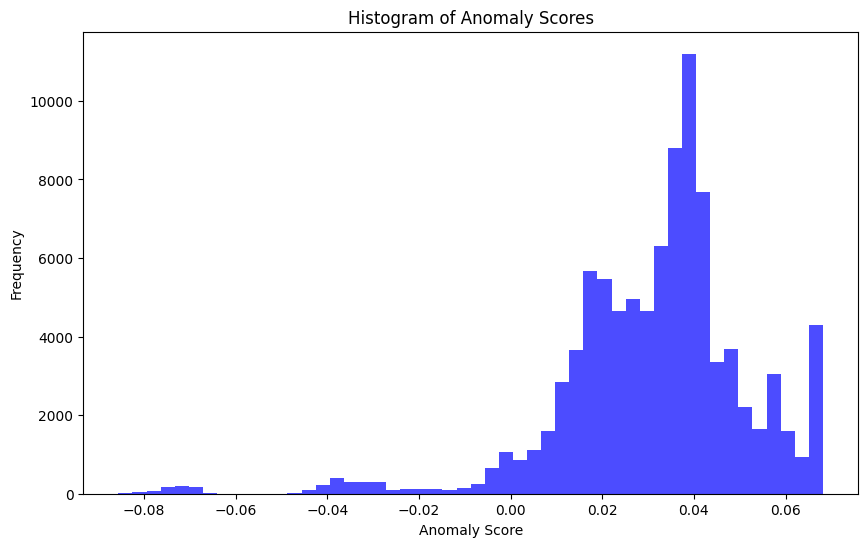

In [32]:
# Calculate anomaly scores (lower is more anomalous)
scores = iso_forest.decision_function(scaled_features)
combined_data['anomaly_score'] = scores

# Visualization of Anomaly Scores
plt.figure(figsize=(10, 6))
plt.hist(scores, bins=50, color='blue', alpha=0.7)
plt.title('Histogram of Anomaly Scores')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.show()

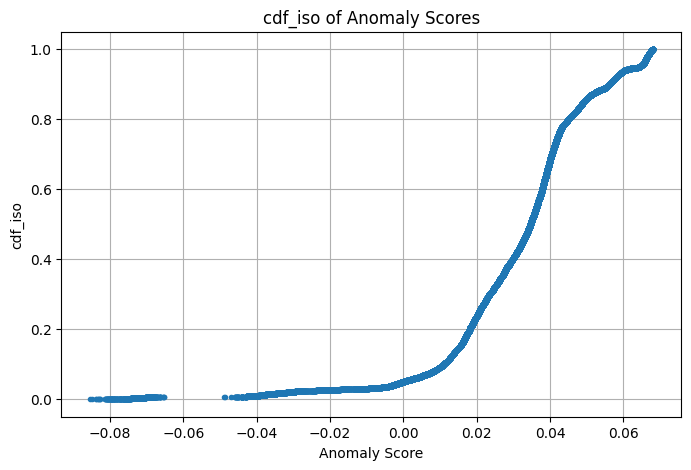

In [33]:
# Calculate the cdf_iso of the anomaly scores
sorted_scores = np.sort(scores)
cdf_iso = np.arange(len(sorted_scores)) / float(len(sorted_scores))

plt.figure(figsize=(8, 5))
plt.plot(sorted_scores, cdf_iso, marker='.', linestyle='none')
plt.xlabel('Anomaly Score')
plt.ylabel('cdf_iso')
plt.title('cdf_iso of Anomaly Scores')
plt.grid(True)
plt.show()

In [51]:
# Set a threshold for anomaly detection
threshold = -0.04

# Mark data points with scores below the threshold as anomalies
combined_data['is_anomaly'] = combined_data['anomaly_score'] < threshold

# Display the anomalies
anomalies = combined_data[combined_data['is_anomaly']]
print(f"Detected {len(anomalies)} anomalies out of {len(combined_data)} records.")


Detected 914 anomalies out of 95125 records.


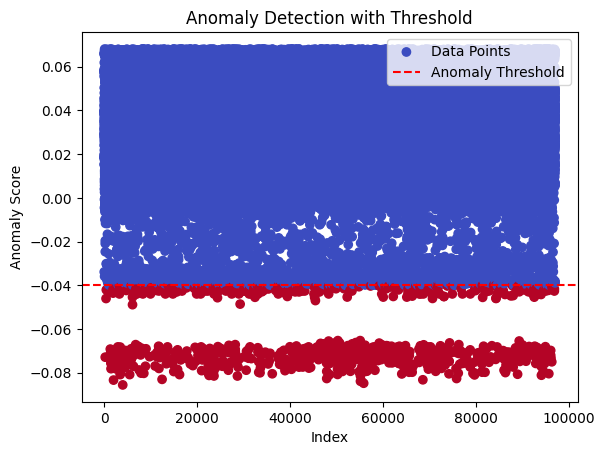

In [52]:
# Visualize the anomaly scores and the threshold
plt.scatter(combined_data.index, combined_data['anomaly_score'], c=combined_data['is_anomaly'], cmap='coolwarm', label='Data Points')
plt.axhline(y=threshold, color='red', linestyle='--', label='Anomaly Threshold')
plt.title('Anomaly Detection with Threshold')
plt.xlabel('Index')
plt.ylabel('Anomaly Score')
plt.legend(loc='upper right')
plt.show()

## Anomaly Date Analysis

Number of anomalies in df_iso: 914


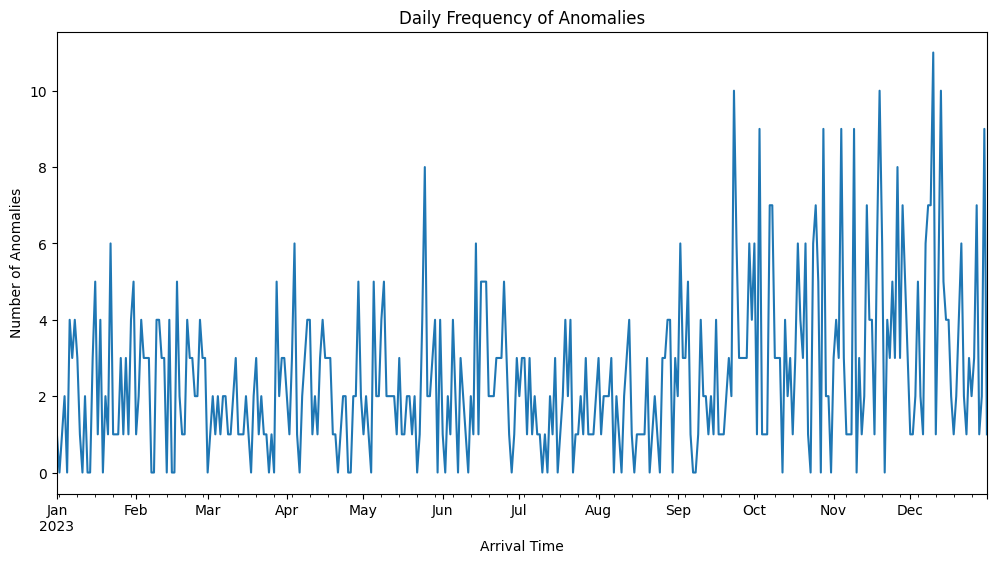

In [53]:
# Create DataFrame for anomalies
df_iso = anomalies.copy()
df_iso['MSE'] = mse[df_iso.index]  # Adding the MSE values to the DataFrame
print("Number of anomalies in df_iso:", df_iso.shape[0])

# Ensure 'Arrival Time' is in datetime format (if not already)
df_iso['Arrival Time'] = pd.to_datetime(df_iso['Arrival Time'])

# Add 'Count' column before resampling
df_iso['Count'] = 1

plt.figure(figsize=(12, 6))

# Set index to 'Arrival Time'
df_iso.set_index('Arrival Time', inplace=True)

# Resample and count by day (assuming daily data)
daily_anomalies = df_iso.resample('D')['Count'].sum()
daily_anomalies.plot(figsize=(12, 6))  # Adjust figure size as needed

plt.title('Daily Frequency of Anomalies')
plt.ylabel('Number of Anomalies')
plt.show()

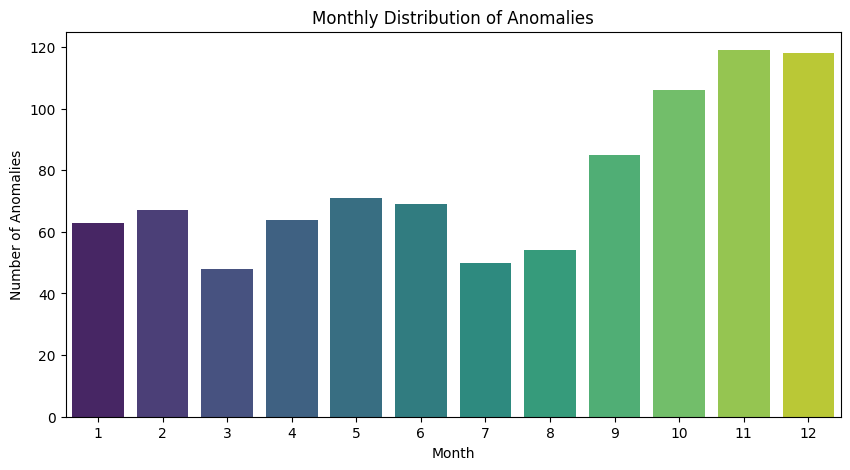

In [54]:
# Plot the monthly distribution of anomalies
monthly_counts_iso = df_iso['Month'].value_counts().sort_index()
plt.figure(figsize=(10, 5))
sns.barplot(x=monthly_counts_iso.index, y=monthly_counts_iso.values, palette='viridis')
plt.title('Monthly Distribution of Anomalies')
plt.xlabel('Month')
plt.ylabel('Number of Anomalies')
plt.show()

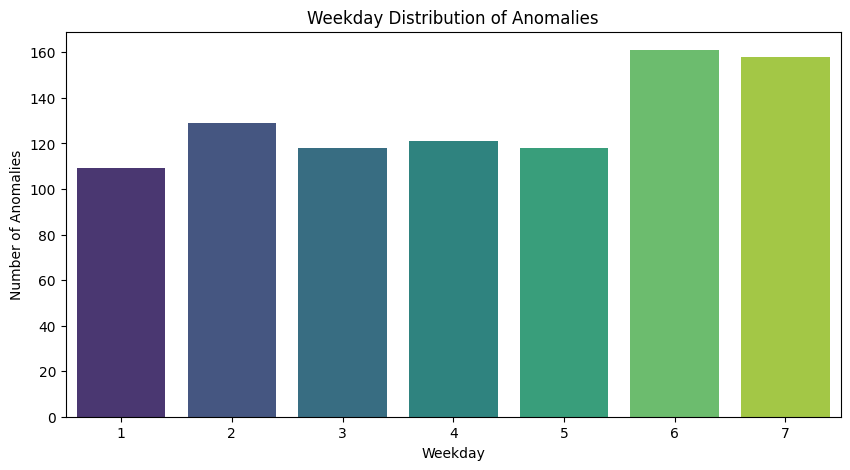

In [55]:
# Weekday Distribution of Anomalies
weekday_counts_iso = df_iso['Weekday'].value_counts().sort_index()
plt.figure(figsize=(10, 5))
sns.barplot(x=weekday_counts_iso.index, y=weekday_counts_iso.values, palette='viridis')
plt.title('Weekday Distribution of Anomalies')
plt.xlabel('Weekday')
plt.ylabel('Number of Anomalies')
plt.show()

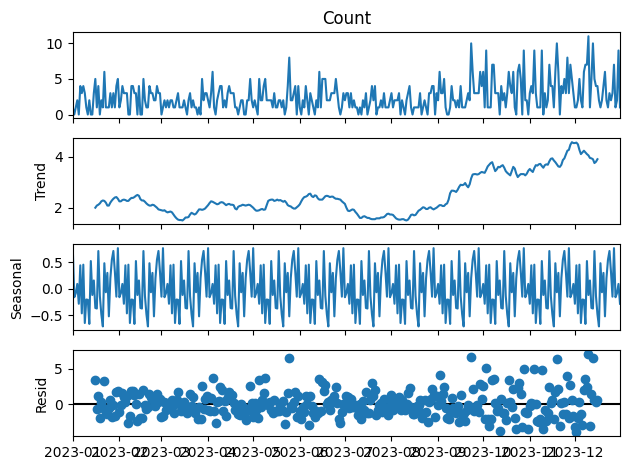

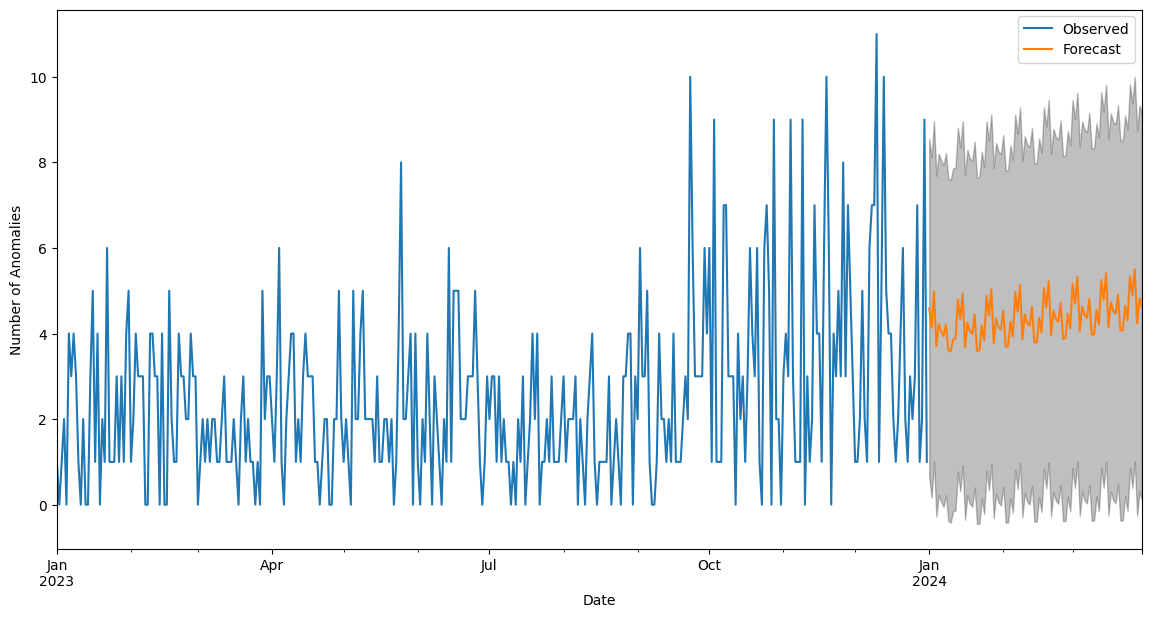

In [56]:
# Seasonal Decomposition
result = seasonal_decompose(daily_anomalies, model='additive', period=30)  # Assuming monthly seasonality
result.plot()
plt.show()

# SARIMAX Model
model = SARIMAX(daily_anomalies, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
fitted_model = model.fit(disp=False)

# Predict the next 90 days (assuming daily data)
preds = fitted_model.get_forecast(steps=90)
pred_ci = preds.conf_int()

# Visualize the Predictions
plt.figure(figsize=(14, 7))
ax = daily_anomalies.plot(label='Observed')
preds.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')  # Change label if not daily data
ax.set_ylabel('Number of Anomalies')
plt.legend()
plt.show()

1. Count:
This chart shows the raw count of anomaly events over time. There are several significant peaks throughout the year, especially towards the end, indicating possible increases in anomalous activity at specific times.

2. Trend:
The trend chart reveals the long-term movement in the data. It shows a slight upward trend over the course of the year, which may indicate an overall increase in the frequency of anomaly events over time, or an increased sensitivity of the detection methods to anomalies.

3. Seasonal:
The seasonality chart displays periodic variations in the data. It clearly shows regular fluctuations that may be related to seasonal factors such as changes in weather, holidays, or other cyclical events. This chart is particularly useful for identifying specific times of the year when anomalous activity is more frequent.

4. Residual:
The residual chart shows the remaining fluctuations after the trend and seasonal factors have been removed. These fluctuations cannot be explained by the model as either trend or seasonality. Ideally, residuals should be close to zero and show no clear patterns. The residuals here are relatively low and stable, indicating that the model has captured the main structure of the data well, though there are still some fluctuations unexplained by the model.

## Weather

In [57]:
# Weather Data
# Assuming anomalies_data_auto has a 'Date' column in date format
# Combine the anomalies data with weather data
matched_weather_iso = pd.merge(df_iso['Date'], weather_data, on='Date', how='inner').sort_values(by='Date')
print(matched_weather_iso.head())

           Date  tempmax  tempmin  temp  feelslikemax  feelslikemin  \
109  2023-01-01     25.0     17.3  21.7          25.0          17.3   
592  2023-01-03     26.0     20.1  22.5          26.0          20.1   
870  2023-01-04     27.0     19.2  22.6          26.6          19.2   
426  2023-01-04     27.0     19.2  22.6          26.6          19.2   
234  2023-01-06     25.1     20.3  21.9          25.1          20.3   

     feelslike   dew  humidity  precip  ...  solarenergy  uvindex severerisk  \
109       21.7  14.4      63.7     0.0  ...         37.4       10         10   
592       22.5  10.8      48.1     0.0  ...         34.4        9         10   
870       22.6   8.4      41.4     0.0  ...         22.8        6         10   
426       22.6   8.4      41.4     0.0  ...         22.8        6         10   
234       21.9  14.7      64.3     0.0  ...         16.4        6         10   

                 sunrise               sunset  moonphase        conditions  \
109  2023-01-0

In [58]:
matched_weather_iso.describe()

,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,...,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase
count,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,...,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000
mean,33.871991,24.860722,29.129322,36.283807,26.491685,31.365646,17.544092,52.917834,0.209081,9.299781,...,22.865098,202.822648,1009.862363,19.090044,9.394967,283.461488,24.501204,8.513129,21.911379,0.476433
std,6.226079,5.718778,5.670250,9.473225,7.839736,8.383467,4.899542,11.087971,1.814495,29.058838,...,4.323579,108.469606,7.132491,18.068996,0.848926,96.911991,8.364744,2.074289,18.816338,0.280933
min,18.200000,13.200000,15.900000,18.200000,13.200000,15.900000,4.200000,19.100000,0.000000,0.000000,...,13.400000,0.300000,995.000000,0.000000,5.300000,27.800000,2.400000,1.000000,10.000000,0.000000
25%,28.400000,19.800000,24.100000,28.300000,19.800000,24.100000,14.000000,46.300000,0.000000,0.000000,...,19.700000,85.800000,1004.300000,4.600000,9.000000,216.400000,18.700000,8.000000,10.000000,0.250000
50%,33.200000,24.500000,28.900000,32.900000,24.500000,28.900000,17.200000,54.800000,0.000000,0.000000,...,22.500000,242.450000,1011.700000,13.300000,9.750000,290.300000,25.100000,9.000000,10.000000,0.480000
75%,39.600000,30.000000,34.500000,44.500000,32.600000,38.600000,21.900000,60.600000,0.000000,0.000000,...,24.900000,284.900000,1015.875000,28.500000,10.000000,368.250000,31.875000,10.000000,30.000000,0.700000
max,46.000000,36.200000,40.000000,57.400000,47.100000,51.500000,28.600000,86.400000,23.800000,100.000000,...,44.900000,359.900000,1023.500000,77.500000,10.600000,499.400000,43.200000,10.000000,100.000000,0.980000


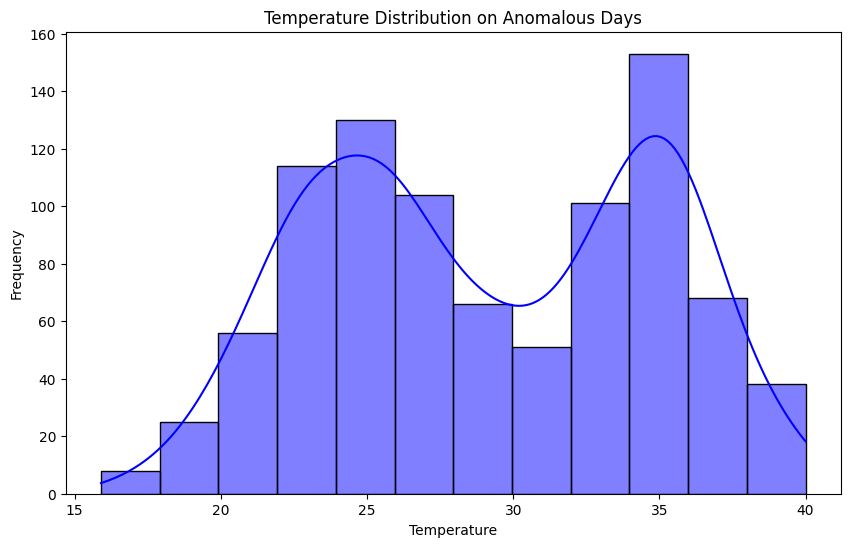

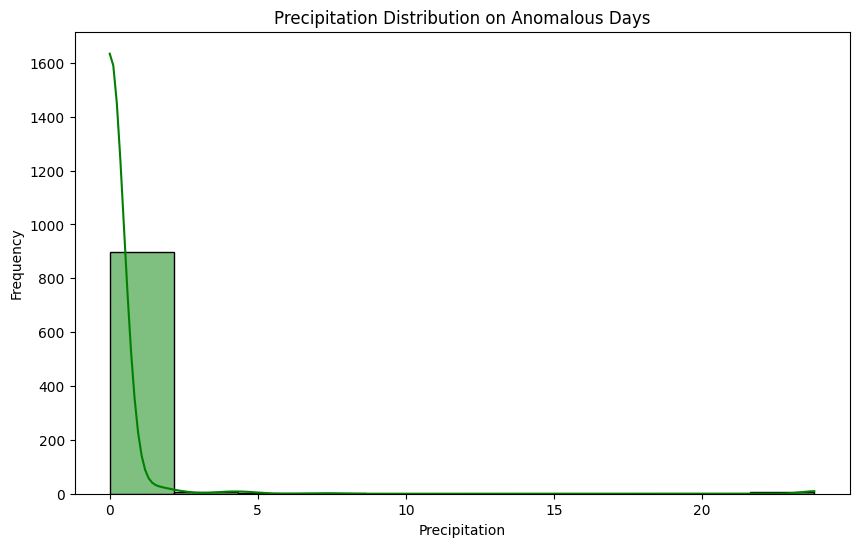

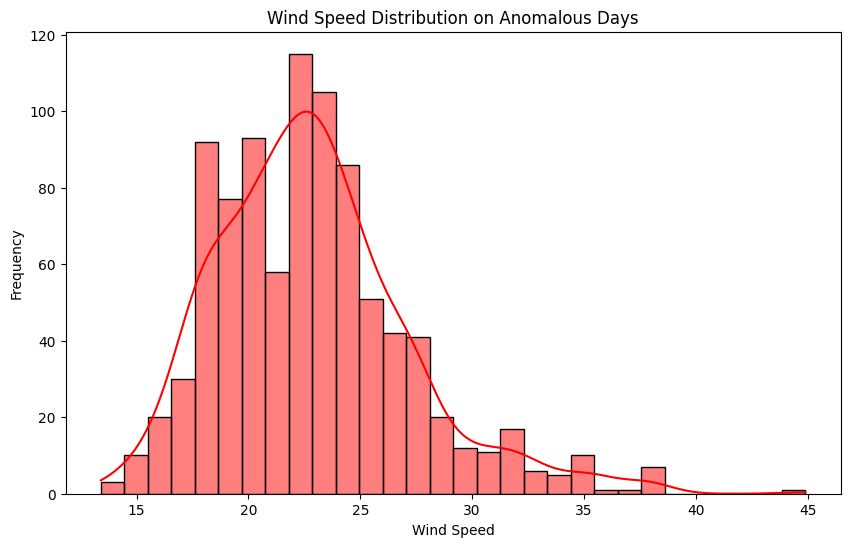

In [59]:
# Plot the weather features on anomalous days

# Temperature
plt.figure(figsize=(10, 6))
sns.histplot(matched_weather_iso['temp'], kde=True, color='blue')
plt.title('Temperature Distribution on Anomalous Days')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()

# Precipitation
plt.figure(figsize=(10, 6))
sns.histplot(matched_weather_iso['precip'], kde=True, color='green')
plt.title('Precipitation Distribution on Anomalous Days')
plt.xlabel('Precipitation')
plt.ylabel('Frequency')
plt.show()

# Wind Speed
plt.figure(figsize=(10, 6))
sns.histplot(matched_weather_iso['windspeed'], kde=True, color='red')
plt.title('Wind Speed Distribution on Anomalous Days')
plt.xlabel('Wind Speed')
plt.ylabel('Frequency')
plt.show()

## Anomaly Main Diagnosis

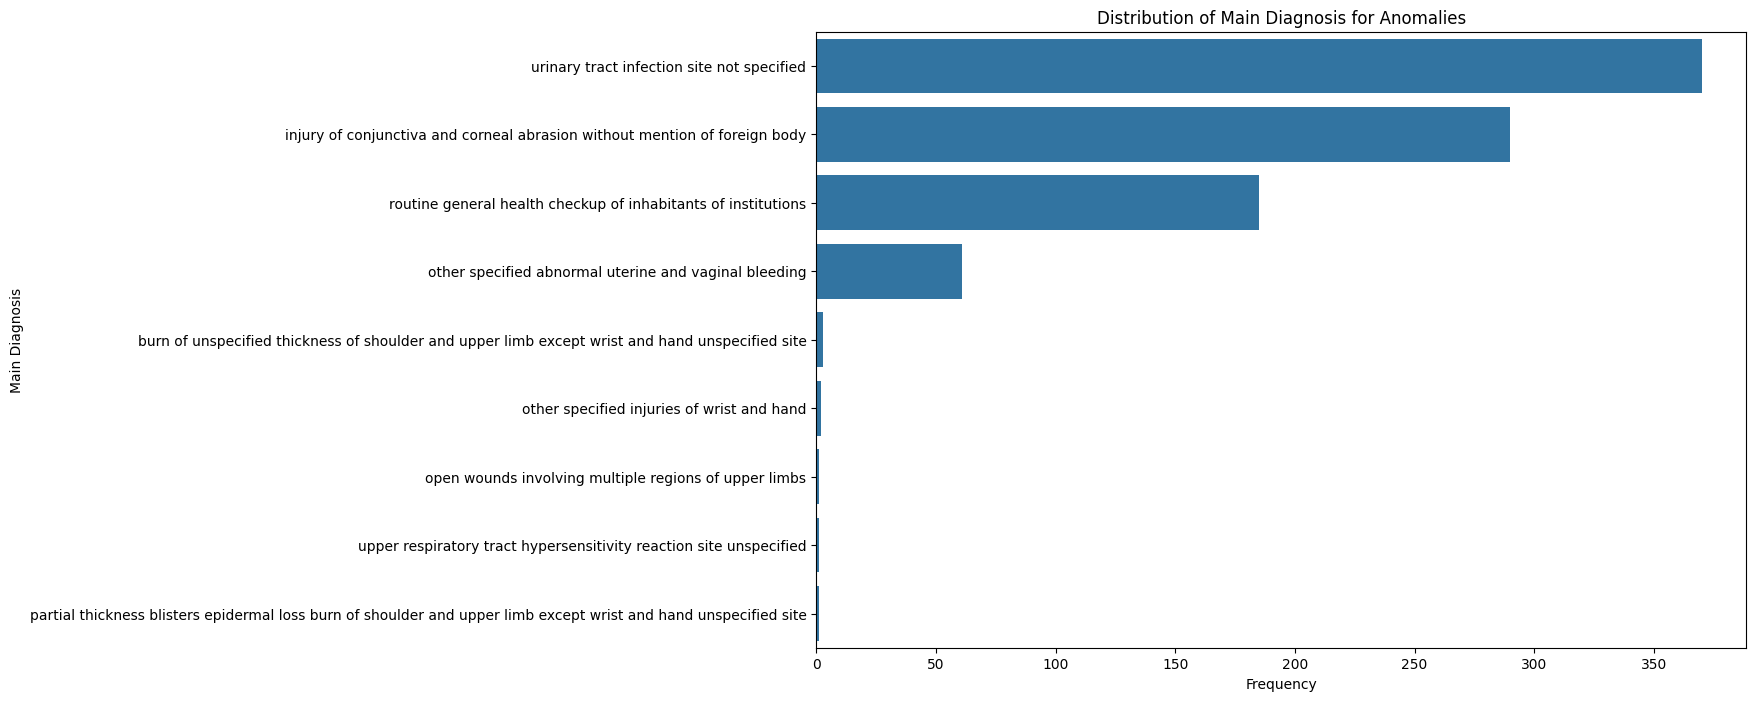

Arrival Time
2023-01-01 06:17:27           urinary tract infection site not specified
2023-01-03 20:05:59    injury of conjunctiva and corneal abrasion wit...
2023-01-04 09:05:51    injury of conjunctiva and corneal abrasion wit...
2023-01-04 20:08:47    other specified abnormal uterine and vaginal b...
2023-01-06 16:51:06           urinary tract infection site not specified
                                             ...                        
2023-12-30 19:33:35    routine general health checkup of inhabitants ...
2023-12-30 19:44:11    routine general health checkup of inhabitants ...
2023-12-30 20:53:24    routine general health checkup of inhabitants ...
2023-12-30 22:31:15    injury of conjunctiva and corneal abrasion wit...
2023-12-31 10:29:18           urinary tract infection site not specified
Name: Main Diagnosis, Length: 914, dtype: object


In [60]:
plt.figure(figsize=(12, 8))
sns.countplot(y='Main Diagnosis', data=df_iso, order=df_iso['Main Diagnosis'].value_counts().index)
plt.title('Distribution of Main Diagnosis for Anomalies')
plt.xlabel('Frequency')
plt.show()

df_iso_sorted = df_iso.sort_index()
print(df_iso_sorted['Main Diagnosis'])

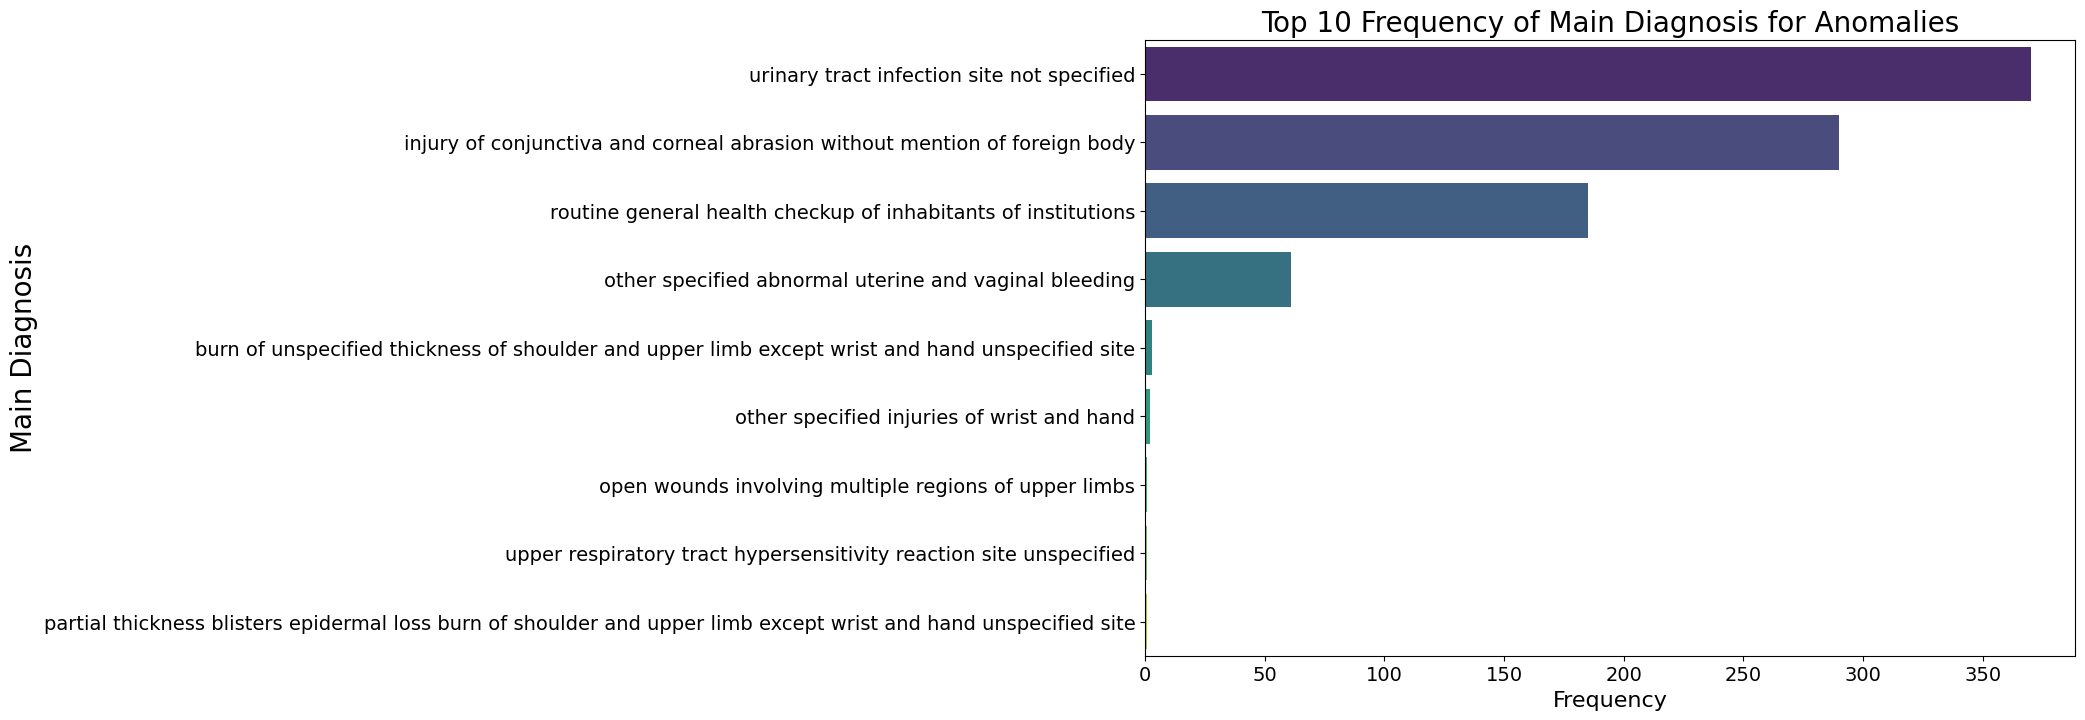

Top 10 Anomalous Main Diagnoses (IsoForest):
1. urinary tract infection site not specified
2. injury of conjunctiva and corneal abrasion without mention of foreign body
3. routine general health checkup of inhabitants of institutions
4. other specified abnormal uterine and vaginal bleeding
5. burn of unspecified thickness of shoulder and upper limb except wrist and hand unspecified site
6. other specified injuries of wrist and hand
7. open wounds involving multiple regions of upper limbs
8. upper respiratory tract hypersensitivity reaction site unspecified
9. partial thickness blisters epidermal loss burn of shoulder and upper limb except wrist and hand unspecified site


In [61]:
# Caculate the frequency of diagnoses and sort the top 10
diagnosis_counts_iso = df_iso['Main Diagnosis'].value_counts().nlargest(10)

# Plot the frequency of the top 10 diagnoses
plt.figure(figsize=(12, 8))
sns.barplot(y=diagnosis_counts_iso.index, x=diagnosis_counts_iso.values, palette='viridis')

plt.title('Top 10 Frequency of Main Diagnosis for Anomalies', fontsize=20)
plt.xlabel('Frequency', fontsize=16)
plt.ylabel('Main Diagnosis', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

print("Top 10 Anomalous Main Diagnoses (IsoForest):")
for idx, diagnosis in enumerate(diagnosis_counts_iso.index, start=1):
    print(f"{idx}. {diagnosis}")

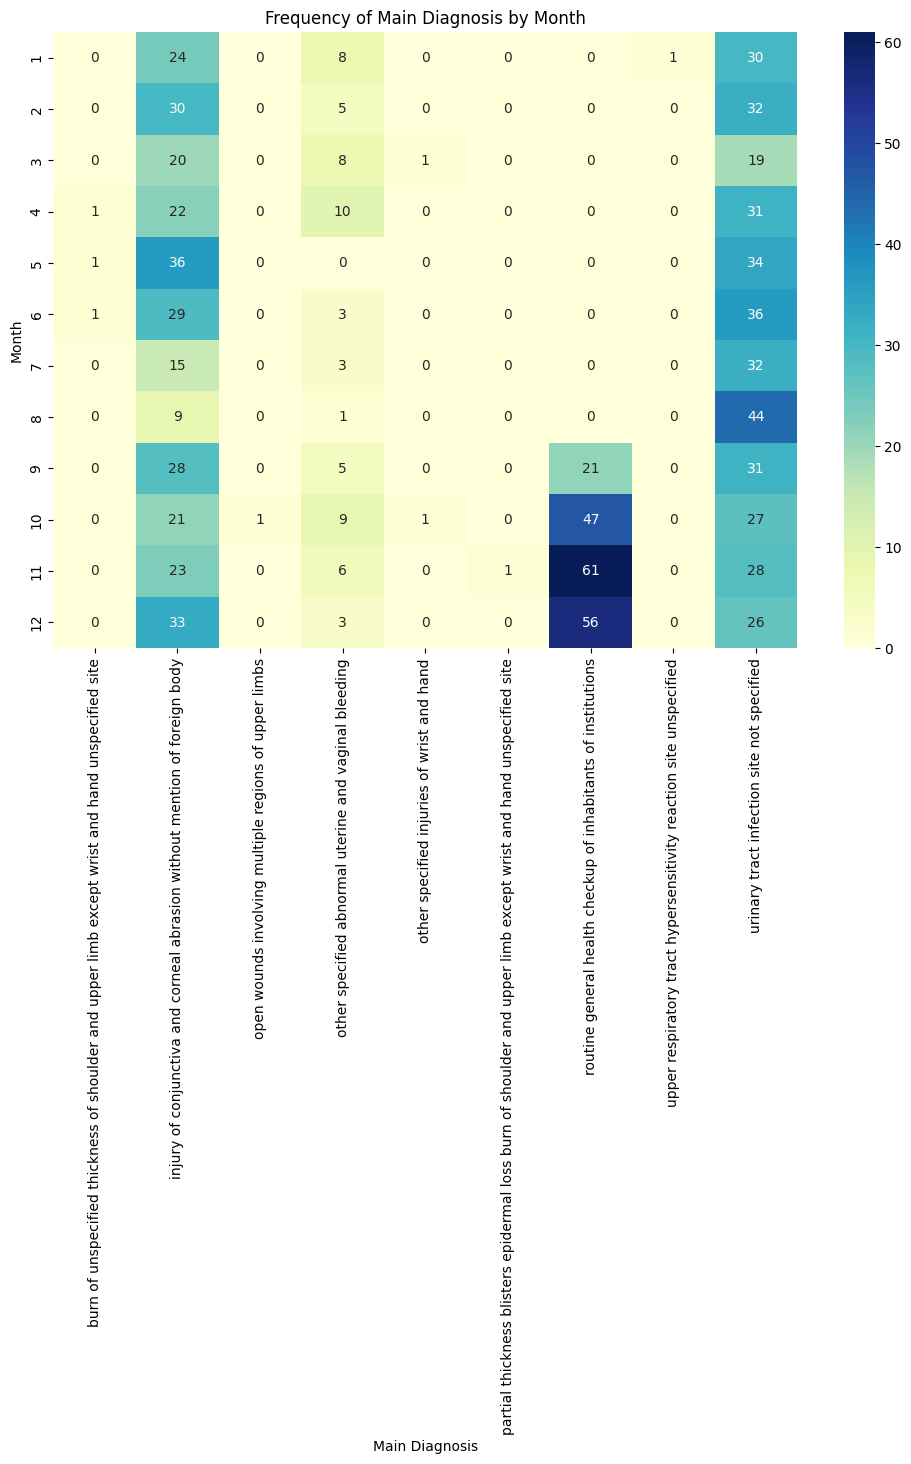

In [62]:
# Group by Month and 'Main Diagnosis' and count occurrences
monthly_diagnosis_iso = df_iso.groupby(['Month', 'Main Diagnosis']).size().unstack(fill_value=0)

# Visualize the data
plt.figure(figsize=(12, 8))
sns.heatmap(monthly_diagnosis_iso, annot=True, cmap="YlGnBu", fmt="d")
plt.title('Frequency of Main Diagnosis by Month')
plt.xlabel('Main Diagnosis')
plt.ylabel('Month')
plt.show()

# Compare the results of the two models

In the unsupervised learning context, comparing different anomaly detection models like autoencoders and isolation forests presents challenges due to their distinct methodologies for assessing accuracy. The autoencoder model primarily relies on metrics such as the loss function and Mean Squared Error (MSE) to evaluate its performance. In contrast, the isolation forest model utilizes anomaly scores to identify anomalies.

Despite these differences in evaluation metrics, when examining the results from both anomaly detection and time series analysis, the isolation forest model demonstrates a stronger ability to capture and illustrate temporal patterns and trends related to anomalies. When analyzing emergency department data, it allows for a deeper understanding of how anomaly occurrences correlate with specific times of the year. Such insights are crucial for linking anomaly events to seasonal and weather-related variations, thereby enhancing the strategic planning and resource allocation within emergency care settings.

To conclude, we choose Isolation Forest model to do the anomaly detection predictions.

## Making New Prediction

In [76]:
import pickle
def make_prediction(Diagnosis,month,time,day):
    """
    Predicts whether a patient is an anomaly case based on given features.

    Args:
        Date (int): The arrival time(Date) of the case.
        Main Diagnosis (str): The main diagnosis of the case.

    Returns:
        str: Prediction of whether the patient is an anomaly case.
    """
    #time=pd.to_datetime(time)
    # Create DataFrame with input data
    data = {
        "Main Diagnosis": [Diagnosis],
        "Month": [month],
        "Hour": [time],
        "Weekday": [day]
    }

    # Create DataFrame from input data
    df_new = pd.DataFrame(data, index=[0])
    with open('nlp.pkl', 'rb') as file:
        vectorizer = pickle.load(file)
    # Assuming a pre-fitted CountVectorizer for 'Main Diagnosis' and pre-trained Isolation Forest model
    # Transform 'Main Diagnosis' using the pre-fitted CountVectorizer
    df_new_encoded = vectorizer.transform(df_new['Main Diagnosis'])
    df_new_features = pd.DataFrame(df_new_encoded.toarray(), columns=vectorizer.get_feature_names_out())

    # Combine all features into one DataFrame
    df_final = pd.concat([df_new_features, df_new['Month'],df_new['Hour'],df_new['Weekday']], axis=1)

    # Predict using the Isolation Forest model
    prediction = iso_forest.predict(df_final)
    
    # Return the prediction result
    if prediction[0] == -1:
        return 'THIS Case Has Higher Probability to be an ANOMALY'
    else:
        return 'THIS CASE IS NOT AN ANOMALY'



In [77]:
make_prediction('open wound of other parts of foot',12,12,5 )

'THIS CASE IS NOT AN ANOMALY'

In [78]:
make_prediction('urinary tract infection site not specified',12,12,5 )

'THIS Case Has Higher Probability to be an ANOMALY'